# ORB walkthrough

Source: https://docs.opencv.org/4.5.2/d1/d89/tutorial_py_orb.html

## Description

ORB is basically a fusion of FAST keypoint detector and BRIEF descriptor with many modifications to enhance the performance.

In [1]:
# imports
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import preprocessing as pre
import cv as cvfunctions

(1953, 2216, 3)


Text(0.5, 1.0, 'Bottom part')

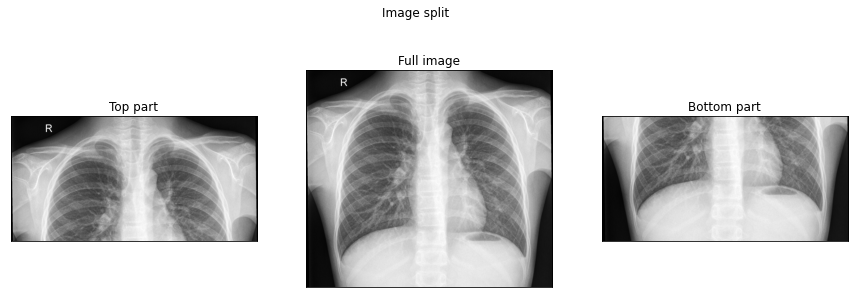

In [2]:
## Image preprocessing 

# choose 1 image: NORMAL2-IM-0329-0001.jpeg
filename = 'NORMAL2-IM-0329-0001.jpeg'
im = cv2.imread('images/x-ray/'+filename)

# divide image into two parts with 30% overlap
full,top,bottom = pre.splitY(0.3,im)

# convert to gray scale
topGray = cv2.cvtColor(top, cv2.COLOR_BGR2GRAY)
bottomGray = cv2.cvtColor(bottom, cv2.COLOR_BGR2GRAY)

fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs = axs.flatten()
for img, ax in zip([top,full,bottom], axs):
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(img)
fig.suptitle('Image split')
axs[0].set_title('Top part')
axs[1].set_title('Full image')
axs[2].set_title('Bottom part')

First it use FAST to find keypoints
by comparing the brightness of pixel $p$ to the surrounding 16 pixels that are in a small circle around $p$. Pixels in the circle is then sorted into three classes (lighter than $p$, darker than $p$ or similar to $p$).

![pixels considered](images/notebooks/orb_ring.jpg "FAST chosen pixels")

If more than 8 pixels are darker or brighter than $p$ than it is selected as a keypoint.




In [4]:
def FAST_keypoints(image):
    num_rows, num_cols = image.shape[:2]
    def isKeypoint(coord):
        (row, col) = coord
        similarity_threshold = np.max(image) * 0.15 # determines number of matches
        # to close to border
        if row < 3 or row > (num_rows - 4) or col < 3 or col > (num_cols - 4):
            return False
        delta = np.array([(-3, 0), (-3, 1), (-2, 2), (-1, 3), 
                        (0, 3),  (1, 3),  (2, 2),  (3, 1),
                        (3, 0),  (3,-1),  (2,-2),  (1,-3),
                        (0,-3), (-1,-3), (-2,-2), (-3,-1)])
        brighter = []
        same = []
        darker = []
        center = image[row,col]
        for dc in delta:
            d_row = dc[0]
            d_col = dc[1]
            neighbor = image[row+d_row,col+d_col]
            difference = float(neighbor) - float(center)
            if difference >= similarity_threshold:
                brighter.append(dc)
            elif -difference >= similarity_threshold:
                darker.append(dc)
            else:
                same.append(dc)
        #print(len(brighter))
        #print(len(same))
        #print(len(darker))
        #return len(brighter) + len(darker) >= 8
        return len(brighter) >= 8 or len(darker) >= 8
    keypoints = []
    for r in range(0, num_rows-1):
      for c in range(0, num_cols-1):
        if isKeypoint((r,c)):
          keypoints.append(cv2.KeyPoint(c, r, 1))
    return keypoints

In [5]:
img = bottomGray
  
scale_percent = 20 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
kp = FAST_keypoints(resized)

Apply Harris corner measure to find top N points among them.

In [6]:
s = 15 # s = [15;50]
eps = 1.3 # eps > 0.5
k = 0.01 # k ~ 0.01
harrisVal = cvfunctions.harrisMeasure(resized, s, eps, k)


In [7]:
def sortByHarrisMeasure(keypoint):
    (c,r) = keypoint.pt
    c = int(c)
    r = int(r)
    return harrisVal[r,c]

kp.sort(reverse=True,key=sortByHarrisMeasure)


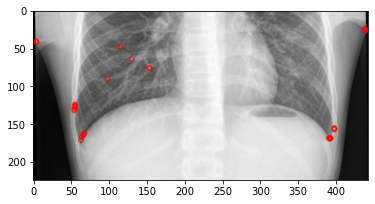

In [8]:
kp_img = cv2.drawKeypoints(resized, kp[:50], None, (255,0,0), flags=0)
plt.imshow(kp_img)

It also use pyramid to produce multiscale-features.

BUT that is skipped in this walkthrough...

In [9]:
# no pyramid...

One problem is that, FAST doesn't compute the orientation. So what about rotation invariance? Authors came up with following modification.

It computes the intensity weighted centroid of the patch with located corner at center. The direction of the vector from this corner point to centroid gives the orientation. To improve the rotation invariance, moments are computed with $x$ and $y$ which should be in a circular region of radius $r$, where $r$ is the size of the patch.

Now for descriptors, ORB use BRIEF descriptors. But we have already seen that BRIEF performs poorly with rotation. So what ORB does is to "steer" BRIEF according to the orientation of keypoints. For any feature set of $n$ binary tests at location $(x_i,y_i)$, define a $2 \times n$ matrix, $S$ which contains the coordinates of these pixels. Then using the orientation of patch, $\Theta$, its rotation matrix is found and rotates the $S$ to get steered(rotated) version $S_\Theta$.



ORB discretize the angle to increments of $\frac{2\pi}{30}$ (12 degrees), and construct a lookup table of precomputed BRIEF patterns. As long as the keypoint orientation $\Theta$ is consistent across views, the correct set of points $S_\Theta$ will be used to compute its descriptor.